In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style('darkgrid')

In [3]:
#Loading the datasets
df1=pd.read_csv('combined_data_1.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df2=pd.read_csv('combined_data_2.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df3=pd.read_csv('combined_data_3.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df4=pd.read_csv('combined_data_4.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

#Converting Rating column to float
df1['Rating']=df1['Rating'].astype(float)
df2['Rating']=df2['Rating'].astype(float)
df3['Rating']=df3['Rating'].astype(float)
df4['Rating']=df4['Rating'].astype(float)
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
print('df_1: ', df1.shape)
print('df_2: ',df2.shape)
print('df_3: ',df3.shape)
print('df_4: ',df4.shape)

df_1:  (24058263, 2)
df_2:  (26982302, 2)
df_3:  (22605786, 2)
df_4:  (26851926, 2)


In [5]:
# Loading the rest of the datasets
titles_df=pd.read_csv('movie_titles.csv', header=None, names=['Movie_Id', 'Year', 'Name'], encoding='ISO-8859-1')
#titles_df.set_index('Movie_Id', inplace=True)
titles_df.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [6]:
#Let's combine all the dataset into one except Movie titles for now
df=df1
df=df.append(df2)
df=df.append(df3)
df=df.append(df4)
df.shape

(100498277, 2)

In [7]:
df.head(5)

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [8]:
#Let's drop the first row since it has nothing
df.drop([0, 1], axis=0).head(5)

,Cust_Id,Rating
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0


In [9]:
df.shape

(100498277, 2)

# Data Exploration


In [10]:
# Let's see how the data is spread:
p=df.groupby('Rating')['Rating'].agg(['count'])
p


,count
Rating,
1.0,4617990
2.0,10132080
3.0,28811247
4.0,33750958
5.0,23168232


In [11]:
print(p.shape)

(5, 1)


In [12]:
# get movie count and find out how many movies are not rated or they are null
movie_count = df.isnull().sum()[1]
movie_count

17770

In [13]:
#get customer count
cust_count=df['Cust_Id'].nunique()-movie_count
cust_count

480189

In [14]:
#get rating count
rating_count = df['Cust_Id'].count() - movie_count

rating_count

100480507

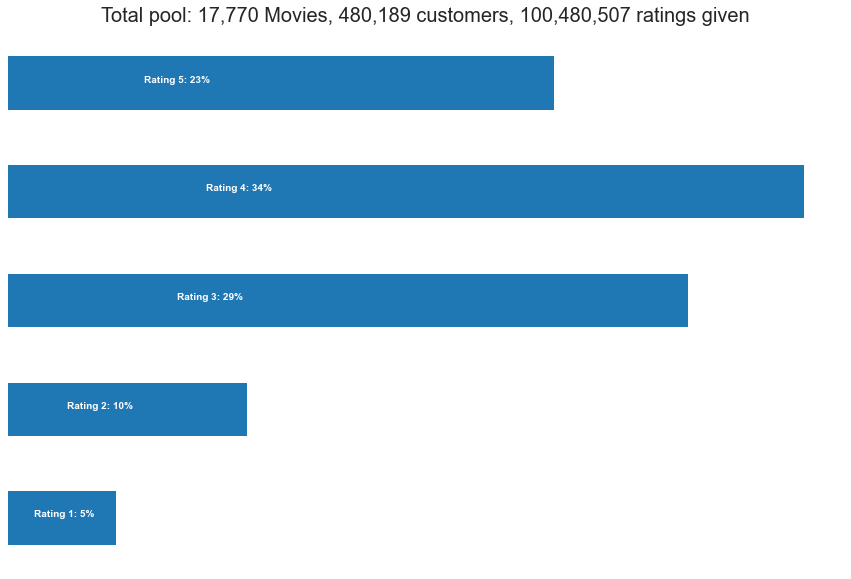

In [15]:

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# Data Cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [16]:
df_new=pd.read_csv('data_netflix.csv')
df_new.head()

,Unnamed: 0,Movie_Id,Cust_Id,Rating
0,56431994,10341,510180,4
1,9056171,1798,510180,5
2,58698779,10774,510180,3
3,48101611,8651,510180,2
4,81893208,14660,510180,2


In [17]:
df_new=df_new.drop(['Unnamed: 0'], axis=1)
df_new.columns=['Movie_Id', 'Cust_Id', 'Rating']
df_new.head()

,Movie_Id,Cust_Id,Rating
0,10341,510180,4
1,1798,510180,5
2,10774,510180,3
3,8651,510180,2
4,14660,510180,2


In [18]:
df_new.shape

(100480507, 3)

In [19]:
# Let's remove movie with too less reviews because they are relatively not popular.
f=['count', 'mean']
df_movie_summary=df_new.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index=df_movie_summary.index.map(int)
movie_benchmark=round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list=df_movie_summary[df_movie_summary['count']<movie_benchmark].index
print('Movie Minimum Times of Review: {}'.format(movie_benchmark))

Movie Minimum Times of Review: 1948.0


In [20]:
#Let's remove customer who give too less reviews because they are relatively less active users.
df_cust_summary=df_new.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index=df_cust_summary.index.map(int)
cust_benchmark=round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list=df_cust_summary[df_cust_summary['count']<cust_benchmark].index
print('Customer Minimum Times of Review: {}'.format(cust_benchmark))

Customer Minimum Times of Review: 211.0


In [21]:
# Let's compare it with the original data size now.
print('Oringal shape: {}'.format(df_new.shape))
df_new=df_new[~df_new['Movie_Id'].isin(drop_movie_list)]
df_new=df_new[~df_new['Cust_Id'].isin(drop_cust_list)]
print('After dropping shape:{}'.format(df_new.shape))
print('-Data Examples-')
print(df_new.iloc[::5000000, :])

Oringal shape: (100480507, 3)
After dropping shape:(71833509, 3)
-Data Examples-
          Movie_Id  Cust_Id  Rating
0            10341   510180       4
6029570      13195   272264       5
12379748      7937   240888       5
18822085      8327   438340       4
25246920     10042  2314206       4
31671044     17057  1986816       5
38243047     15084  1485402       4
44902018      7511  1772573       3
51679542      9442   467092       4
58650360      2376  2160361       5
65656060     11490  2643230       3
73045219      4315  1303781       3
80915647     10739  2457685       2
89001997     10418  1487428       5
97415955      9762   778937       3


In [22]:
# Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:
df_p=pd.pivot_table(df_new, values='Rating', index='Cust_Id', columns='Movie_Id')
print(df_p.shape)

(144380, 5332)


In [23]:
#titles_df.set_index('Movie_Id', inplace=True)
titles_df.head(5)

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [24]:
titles_df.tail()

,Movie_Id,Year,Name
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company
17769,17770,2003.0,Alien Hunter


In [25]:
titles_df=titles_df.dropna()
titles_df.isnull().sum()

Movie_Id    0
Year        0
Name        0
dtype: int64

In [26]:
df_new=df_new.sort_values(by=['Movie_Id'], ascending=True)

In [27]:
df_new.head(5)

,Movie_Id,Cust_Id,Rating
36685452,3,604949,4
38181472,3,1167852,5
44479146,3,2456457,4
10143218,3,425033,3
8111906,3,1269998,3


In [28]:
#Let's merge all the dataframes together
data=pd.merge(df_new, titles_df, on='Movie_Id')
data.head(5)

,Movie_Id,Cust_Id,Rating,Year,Name
0,3,604949,4,1997.0,Character
1,3,1167852,5,1997.0,Character
2,3,2456457,4,1997.0,Character
3,3,425033,3,1997.0,Character
4,3,1269998,3,1997.0,Character


In [29]:
data.shape

(71833509, 5)

In [30]:
data.isnull().sum()

Movie_Id    0
Cust_Id     0
Rating      0
Year        0
Name        0
dtype: int64

In [31]:
#Let's take 40% of the data randomly for recommendation 
split_df=np.random.rand(len(data))<0.4
df=data[split_df]
df.shape

(28733201, 5)

In [32]:
df.to_csv(r'half_data.csv')

In [33]:
df=pd.read_csv('half_data.csv')
df=df.drop(['Unnamed: 0'], axis=1)
df.head()

,Movie_Id,Cust_Id,Rating,Year,Name
0,3,604949,4,1997.0,Character
1,3,2620317,4,1997.0,Character
2,3,1255507,4,1997.0,Character
3,3,712664,5,1997.0,Character
4,3,1470425,4,1997.0,Character


In [34]:
#Let's see how many movies someone with this customer_ID '2331444' has watched and rated 
df_2331444=df[df['Cust_Id']==2331444].sort_values(by=['Rating'])
df_2331444

,Movie_Id,Cust_Id,Rating,Year,Name
115434,118,2331444,1,1985.0,Rambo: First Blood Part II
10311974,6386,2331444,1,1992.0,Sister Act
7001071,4577,2331444,1,1989.0,Steel Magnolias
13860448,8682,2331444,1,1965.0,Thunderball
4349412,2913,2331444,1,2004.0,Finding Neverland
...,...,...,...,...,...
21545513,13593,2331444,5,1997.0,Life Is Beautiful
13944796,8744,2331444,5,1971.0,Monty Python's And Now for Something Completel...
2978891,2001,2331444,5,1992.0,Under Siege
26952359,16721,2331444,5,1972.0,Dirty Harry


In [35]:
#Let's see how many movies someone with this customer_ID '425033' has watched and rated 
df_425033=df[df['Cust_Id']==425033].sort_values(by=['Year'])
df_425033[['Name','Rating', 'Year']]

,Name,Rating,Year
12037835,Gone with the Wind: Collector's Edition,4,1939.0
12453305,Rebecca,3,1940.0
4954180,The Maltese Falcon,4,1941.0
6850517,To Have and Have Not,4,1944.0
12057296,The Big Sleep,5,1946.0
...,...,...,...
8446174,Agatha Christie's Poirot: Death on the Nile,4,2004.0
8392078,Shark Tale,3,2004.0
6477185,The Passion of the Christ,1,2004.0
713894,Kill Bill: Vol. 2,4,2004.0


# Collaborative Filtering with SVD Model

In [36]:
#pip install scikit-surprise

In [40]:
#The data is too big to be run by my laptop. So, I take only 10% of the data randomly for recommendation 
split_df=np.random.rand(len(df_new))<0.1
df=df_new[split_df]
df.shape

(7181214, 3)

In [42]:
import surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate

reader=Reader()

data=Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
svd=SVD()
data

In [43]:
# Lets run 5-fold cross_validation and the result shows.
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9120  0.9116  0.9109  0.9111  0.9116  0.9114  0.0004  
MAE (testset)     0.7139  0.7136  0.7127  0.7131  0.7137  0.7134  0.0005  
Fit time          460.31  433.84  431.97  1141.51 448.76  583.28  279.31  
Test time         32.39   29.03   28.40   44.57   82.20   43.32   20.29   


{'test_rmse': array([0.9119941 , 0.91158667, 0.91087681, 0.91111801, 0.91163252]),
 'test_mae': array([0.71393488, 0.71364822, 0.7126724 , 0.71313609, 0.71368421]),
 'fit_time': (460.3059277534485,
  433.83762288093567,
  431.9687292575836,
  1141.5140979290009,
  448.7561378479004),
 'test_time': (32.39313578605652,
  29.029396057128906,
  28.39560079574585,
  44.571605920791626,
  82.1974458694458)}

In [44]:
trainset=data.build_full_trainset()
svd.fit(trainset)

# Recommending Movies

In [48]:
# It is time to recommand movie to customer "2331444".
titles=titles_df.copy()
titles['Estimate_Rating']=titles['Movie_Id'].apply(lambda x:svd.predict(2331444, x).est)
titles=titles.sort_values(by=['Estimate_Rating'], ascending=False)
titles.head(15)

,Movie_Id,Year,Name,Estimate_Rating
15499,15500,2001.0,Gilmore Girls: Season 2,4.939126
2113,2114,2002.0,Firefly,4.891639
6039,6040,2004.0,The L Word: Season 1,4.767906
5548,5549,2001.0,Curb Your Enthusiasm: Season 2,4.755485
10642,10643,1992.0,Seinfeld: Season 4,4.721947
11924,11925,2003.0,The Wire: Season 2,4.704615
11049,11050,1977.0,MASH: Season 6,4.665257
8534,8535,1990.0,The Simpsons: Season 2,4.638016
1356,1357,2003.0,Stargate SG-1: Season 7,4.634306
11661,11662,2004.0,The Sopranos: Season 5,4.624665
